# Project: Investigate a Dataset - TMDb movie data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

I've selected the "**TMDb movie data**" dataset. I chose this because I am a big fan of films from all decades, and I found it interesting for my analysis. Since I am genuinely interested in films, it made it easier to formulate the questions.

#### I will be answering the following questions:

1. What are the most popular genres (by movie count)?
2. Is there a correlation between rating and runtime?
3. What is the average runtime depending on the genre?
4. What is the average budget depending on the genre?
5. Have movies become more expensive over time (After considering inflation)?
6. What are the most commercially succesful movies by revenue? How about for adjusted revenue?
7. What are the most succesful movies by rating?
8. What are the average amount of movies a director has done?

In [1]:
#My imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### Loading the data
I loaded the data directly from the URI as the read_csv method allows it

In [2]:
tmdb_dataframe_uri = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd1c4c_tmdb-movies/tmdb-movies.csv';
df_tmdb = pd.read_csv(tmdb_dataframe_uri)

Now I will do a quick "head" check to view a sample row of the dataset

In [3]:
df_tmdb.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


Let's check the types of the items to see if any needs to be changed

In [4]:
df_tmdb.dtypes

id                        int64
imdb_id                  object
popularity              float64
budget                    int64
revenue                   int64
original_title           object
cast                     object
homepage                 object
director                 object
tagline                  object
keywords                 object
overview                 object
runtime                   int64
genres                   object
production_companies     object
release_date             object
vote_count                int64
vote_average            float64
release_year              int64
budget_adj              float64
revenue_adj             float64
dtype: object

I didn't identify any value that needs to have its type changed, therefore no need to modify any types.

Moving on, let's see how big this dataset is.

In [5]:
df_tmdb.shape

(10866, 21)

This is a big dataset, let's check for duplicates

In [6]:
df_tmdb.duplicated().sum()

1

In [7]:
#Ok there is one, lets look for it by id
df_tmdb[df_tmdb.duplicated()]['id']

2090    42194
Name: id, dtype: int64

In [8]:
#let's see the actual data
df_tmdb.query('id == 42194')

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
2089,42194,tt0411951,0.59643,30000000,967000,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...,NaN,Dwight H. Little,Survival is no game,...,"In the year of 2039, after World Wars destroy ...",92,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/10,110,5.0,2010,30000000.0,967000.0
2090,42194,tt0411951,0.59643,30000000,967000,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...,NaN,Dwight H. Little,Survival is no game,...,"In the year of 2039, after World Wars destroy ...",92,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/10,110,5.0,2010,30000000.0,967000.0


In [9]:
#Let's drop duplicates, we don't need them
df_tmdb.drop_duplicates(inplace=True)

In [10]:
#Checking acount to see if they are there, response should be "0"
df_tmdb.duplicated().sum()

0

In [11]:
df_tmdb.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7929
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

Here I see that director is empty on 44 movies. I will also be dropping these since I need director information to answer some of the questions

### Wrangling - Dropping films without director

In [12]:
df_tmdb.shape

(10865, 21)

In [13]:
#Create new dataset based on a mask of the rows with not null values on director
df_tmdb = df_tmdb[df_tmdb.director.notnull()]
df_tmdb.isnull().sum()

id                         0
imdb_id                    6
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      70
homepage                7895
director                   0
tagline                 2790
keywords                1465
overview                   3
runtime                    0
genres                    21
production_companies    1007
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [14]:
df_tmdb.shape

(10821, 21)

### Wrangling - Dropping films without genres
I will be using genres in my analysis, therefore I will create a new dataset exclusing the movies that have no genre

In [15]:
#How many rows do we have to drop?
df_tmdb.genres.isnull().sum()

21

In [16]:
df_tmdb = df_tmdb[df_tmdb.genres.notnull()]
#Let's validate that the 21 rows are not included in this dataset
df_tmdb.shape[0]

10800

In [17]:
#Now I double check that there are no null values in genres
df_tmdb.isnull().sum()

id                         0
imdb_id                    5
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      69
homepage                7879
director                   0
tagline                 2774
keywords                1449
overview                   2
runtime                    0
genres                     0
production_companies     994
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

To improve performance and readability, let's limit the dataframe to only have the specific columns we need to answer our questions.

1. id
2. popularity
3. budget_adj
4. revenue_adj
5. original_title
6. director
7. overview
8. runtime
9. genres
10. production_companies
11. release_date
12. vote_count
13. vote_average
14. release_year

In [18]:
columns = ['id','popularity','budget','budget_adj','revenue','revenue_adj','original_title','director',
           'overview','runtime','genres','production_companies','release_date','vote_count',
           'vote_average','release_year']

In [19]:
df_tmdb = df_tmdb[columns]

In [20]:
df_tmdb.dtypes

id                        int64
popularity              float64
budget                    int64
budget_adj              float64
revenue                   int64
revenue_adj             float64
original_title           object
director                 object
overview                 object
runtime                   int64
genres                   object
production_companies     object
release_date             object
vote_count                int64
vote_average            float64
release_year              int64
dtype: object

In [21]:
df_tmdb.head(1)

,id,popularity,budget,budget_adj,revenue,revenue_adj,original_title,director,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year
0,135397,32.985763,150000000,1.379999e+08,1513528810,1.392446e+09,Jurassic World,Colin Trevorrow,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015


<a id='eda'></a>
## Exploratory Data Analysis

## <font color=green>1. What are the most popular genres (by movie count)</font>

In [22]:
#Let me look at how the genres are displayed
df_tmdb.genres.head(5)

0    Action|Adventure|Science Fiction|Thriller
1    Action|Adventure|Science Fiction|Thriller
2           Adventure|Science Fiction|Thriller
3     Action|Adventure|Science Fiction|Fantasy
4                        Action|Crime|Thriller
Name: genres, dtype: object

In [23]:
list_of_genres = []
for genres in df_tmdb.genres:
    list_of_genres.extend(genres.split('|'))

In [24]:
#using numpy to get the unique genres after splitting
list_of_genres = np.unique(list_of_genres)

In [25]:
for genre in list_of_genres:
    print(genre)

Action
Adventure
Animation
Comedy
Crime
Documentary
Drama
Family
Fantasy
Foreign
History
Horror
Music
Mystery
Romance
Science Fiction
TV Movie
Thriller
War
Western


In [26]:
#Counting the number of films that have each genre listed
genres_count = dict.fromkeys(list_of_genres, 0)

for movie_genres in df_tmdb.genres:
    for genre in list_of_genres:
        if genre in movie_genres:
            genres_count[genre] += 1

genres_count

{'Action': 2378,
 'Adventure': 1466,
 'Animation': 692,
 'Comedy': 3782,
 'Crime': 1353,
 'Documentary': 509,
 'Drama': 4754,
 'Family': 1223,
 'Fantasy': 912,
 'Foreign': 185,
 'History': 332,
 'Horror': 1636,
 'Music': 402,
 'Mystery': 809,
 'Romance': 1708,
 'Science Fiction': 1223,
 'TV Movie': 162,
 'Thriller': 2904,
 'War': 270,
 'Western': 164}

In [27]:
#Creating a specific dataframe to answer this question
genres_count_df = pd.Series(genres_count).to_frame('Count')

#### Plotting with Pandas

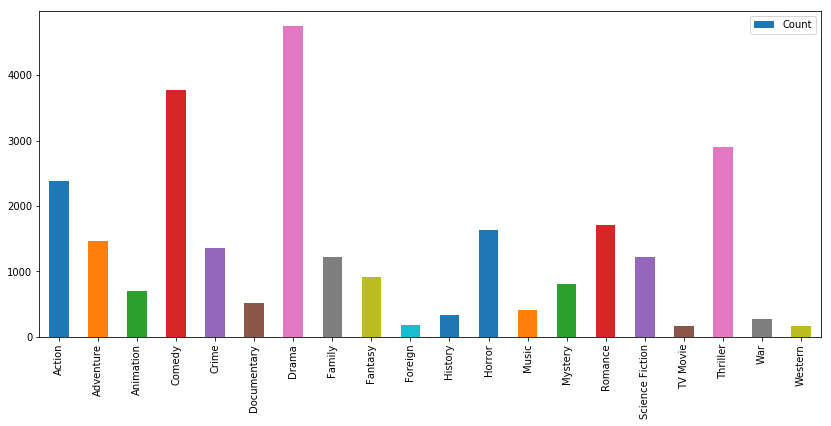

In [28]:
genres_count_df.plot(y = 'Count', kind='bar', figsize=(14,6));

#### Plotting with matplotlib

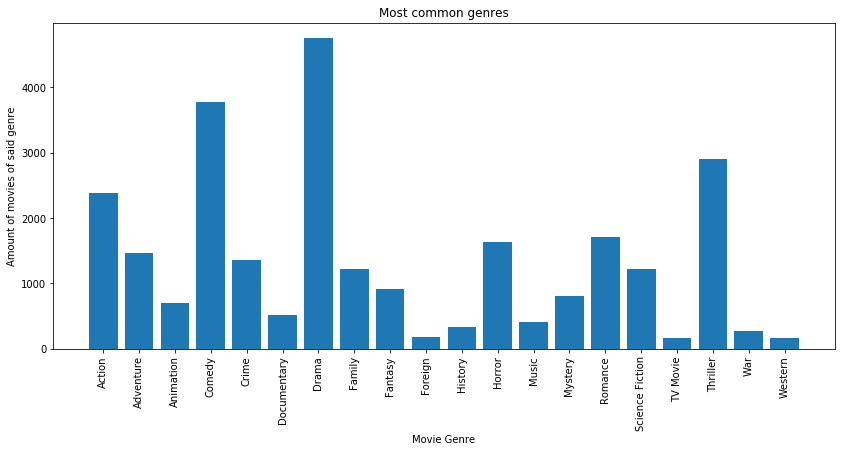

In [29]:
x_axis = genres_count_df.index
y_axis = genres_count_df.Count
plt.figure(figsize=(14,6))
plt.bar(x_axis, y_axis);
plt.title('Most common genres')
plt.xlabel('Movie Genre');
plt.xticks(rotation='vertical')
plt.ylabel('Amount of movies of said genre');

#### In summary, here are the top 5 most common movie genres in the dataset

In [30]:
most_common_genres_df = genres_count_df.sort_values(by='Count', ascending=False).head(5)
most_common_genres_df

,Count
Drama,4754
Comedy,3782
Thriller,2904
Action,2378
Romance,1708


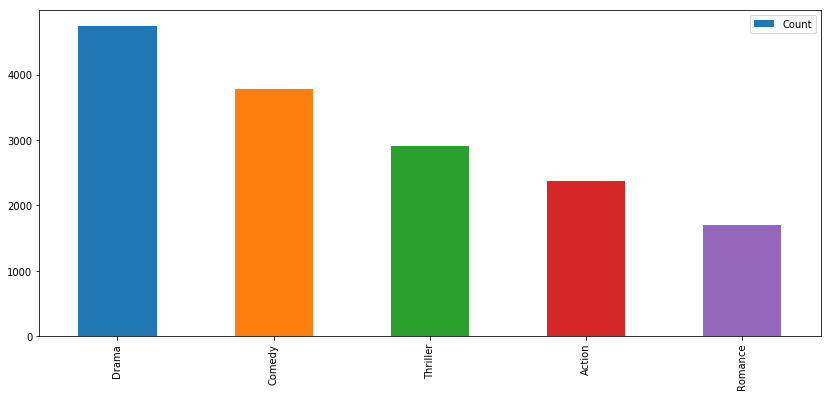

In [31]:
most_common_genres_df.plot(y = 'Count', kind='bar', figsize=(14,6));

### <font color=red>Answer to question #1</font>
The top 5 genres (not by vote but by the amount of movies made of said genre) are:
1. Drama
2. Comedy
3. Thriller
4. Action
5. Romance

I asked a few people what their top 3 genres are, and the majority included at least 2 of this list.

## <font color=green> 2. Is there a correlation between rating and runtime? </font>

Let's see if people tend to give lower ratings to shorter movies, and if longer movies have any impact on perceived quality of the film, resulting in higher ratings

In [32]:
runtime_rating_df = df_tmdb[['runtime', 'vote_average']]

print(runtime_rating_df.dtypes)

runtime           int64
vote_average    float64
dtype: object


In [33]:
runtime_rating_df.corr()

,runtime,vote_average
runtime,1.000000,0.165142
vote_average,0.165142,1.000000


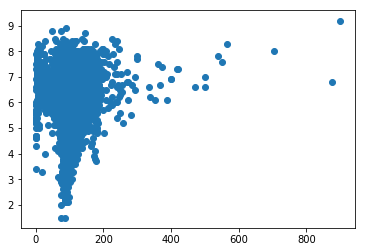

In [34]:
plt.scatter(runtime_rating_df.runtime, runtime_rating_df.vote_average);

In [35]:
runtime_rating_df.runtime.max()

900

I see some values that are outliers (after 200 mins, movies are over 3h20m long, those are not very common, and the max runtime seems to be 900!). Let's take these outliers out and try again

In [36]:
runtime_rating_df = runtime_rating_df.query('runtime <= 200')

runtime_rating_df.runtime.max()

200

In [37]:
runtime_rating_df.corr()

,runtime,vote_average
runtime,1.000000,0.150747
vote_average,0.150747,1.000000


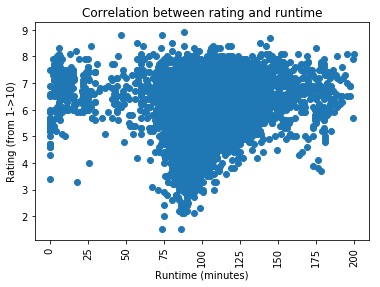

In [38]:
plt.title('Correlation between rating and runtime')
plt.xlabel('Runtime (minutes)');
plt.xticks(rotation='vertical')
plt.ylabel('Rating (from 1->10)');
plt.scatter(runtime_rating_df.runtime, runtime_rating_df.vote_average);

### <font color=red>Answer to question #2</font>

There doesn't seem to be any correlation between movie rating and runtime (the df.corr() function showed it, but graphically it is easier to see)

## <font color=green>3. What is the average runtime depending on the genre?</font>

For this, I will have to use again the separated genres. Luckily I already have a list of separated genres declared above.

In [39]:
#First I create a dataframe with the columns as the list of genres
genre_runtime_df = pd.DataFrame(columns = list_of_genres)
genre_runtime_df.dtypes

Action             object
Adventure          object
Animation          object
Comedy             object
Crime              object
Documentary        object
Drama              object
Family             object
Fantasy            object
Foreign            object
History            object
Horror             object
Music              object
Mystery            object
Romance            object
Science Fiction    object
TV Movie           object
Thriller           object
War                object
Western            object
dtype: object

I see that all values are strings, however I need them to be in integers

In [40]:
genre_runtime_df = genre_runtime_df.astype('int16')
genre_runtime_df.dtypes

Action             int16
Adventure          int16
Animation          int16
Comedy             int16
Crime              int16
Documentary        int16
Drama              int16
Family             int16
Fantasy            int16
Foreign            int16
History            int16
Horror             int16
Music              int16
Mystery            int16
Romance            int16
Science Fiction    int16
TV Movie           int16
Thriller           int16
War                int16
Western            int16
dtype: object

Excellent, now let's fill this temporary dataframe with the runtime values from the original depending on genre

In [41]:
# %%timeit
# #This was taking fovever, so I decided to timeit

# for index, movie in df_tmdb.iterrows():
#     temp_row = pd.Series()
#     for genre in list_of_genres:
#         if genre in movie.genres:
#             temp_row[genre] = movie.runtime

_30.3 s ± 166 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)_

I reviewed the code and decided to add "break" after finding the genre and creating/updating the temp row since the remaining iterations wouldn't do anything as the genre had already been found.

After this, I timed it again:

In [42]:
# %%timeit

# for index, movie in df_tmdb.iterrows():
#     temp_row = pd.Series()
#     for genre in list_of_genres:
#         if genre in movie.genres:
#             temp_row[genre] = movie.runtime
#             break

_13.4 s ± 74.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)_

The first method took 30 seconds, this one took 13, over a 50% time reduction.

In [43]:
for index, movie in df_tmdb.iterrows():
    temp_row = pd.Series()
    for genre in list_of_genres:
        if genre in movie.genres:
            temp_row[genre] = movie.runtime
            genre_runtime_df = genre_runtime_df.append(temp_row, ignore_index=True)
#             break

In [44]:
genre_runtime_df.shape

(26864, 20)

Now let's calculate the mean duration of each genre

In [45]:
genre_runtime_df = genre_runtime_df.mean(skipna=True)

In [46]:
genre_runtime_df

Action             105.665422
Adventure          105.425022
Animation           70.206263
Comedy              98.028749
Crime              107.898198
Documentary        101.306268
Drama              110.893381
Family              91.864329
Fantasy            100.862454
Foreign            107.323988
History            135.942379
Horror              95.540790
Music              105.717472
Mystery            106.113503
Romance            107.344262
Science Fiction    100.460261
TV Movie            95.988764
Thriller           103.392315
War                127.700730
Western            114.871951
dtype: float64

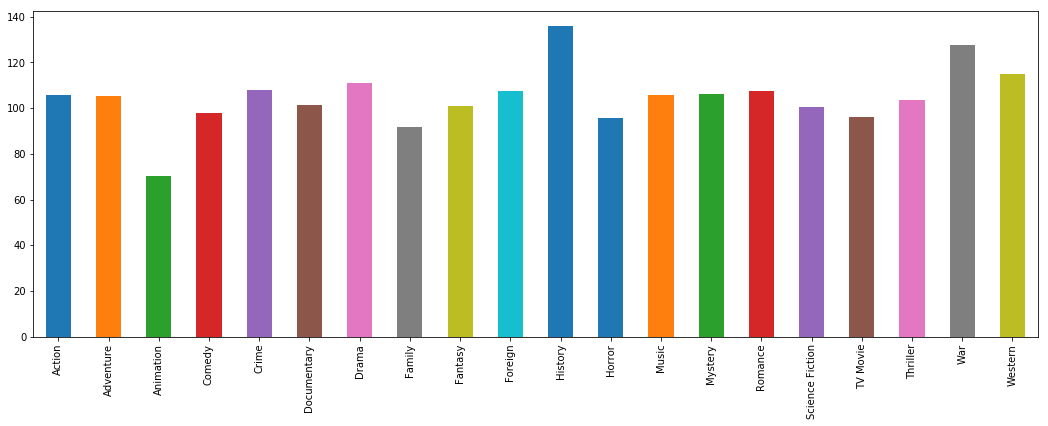

In [47]:
genre_runtime_df.plot(y = genre_runtime_df.values, kind='bar', figsize=(18,6));

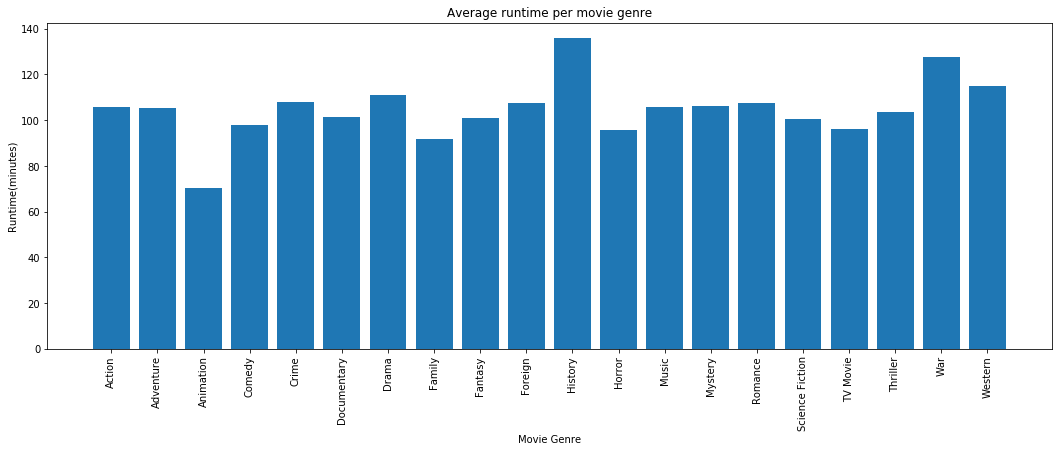

In [48]:
x_axis = genre_runtime_df.index
y_axis = genre_runtime_df.values
plt.figure(figsize=(18,6))
plt.bar(x_axis, y_axis);
plt.title('Average runtime per movie genre')
plt.xlabel('Movie Genre');
plt.xticks(rotation='vertical')
plt.ylabel('Runtime(minutes)');

Besides the min and max values, all other films look to be similar in the chart. 

### Let's sort them to better see the data

In [49]:
#First I'll rename the column and revert back to a DF (It was a Series after the df.mean method call)
genre_runtime_df = genre_runtime_df.to_frame().rename(columns={0:'average_duration'})

In [50]:
genre_runtime_df

,average_duration
Action,105.665422
Adventure,105.425022
Animation,70.206263
Comedy,98.028749
Crime,107.898198
Documentary,101.306268
Drama,110.893381
Family,91.864329
Fantasy,100.862454
Foreign,107.323988


In [51]:
genre_runtime_df.sort_values('average_duration', inplace=True)
genre_runtime_df

,average_duration
Animation,70.206263
Family,91.864329
Horror,95.540790
TV Movie,95.988764
Comedy,98.028749
Science Fiction,100.460261
Fantasy,100.862454
Documentary,101.306268
Thriller,103.392315
Adventure,105.425022


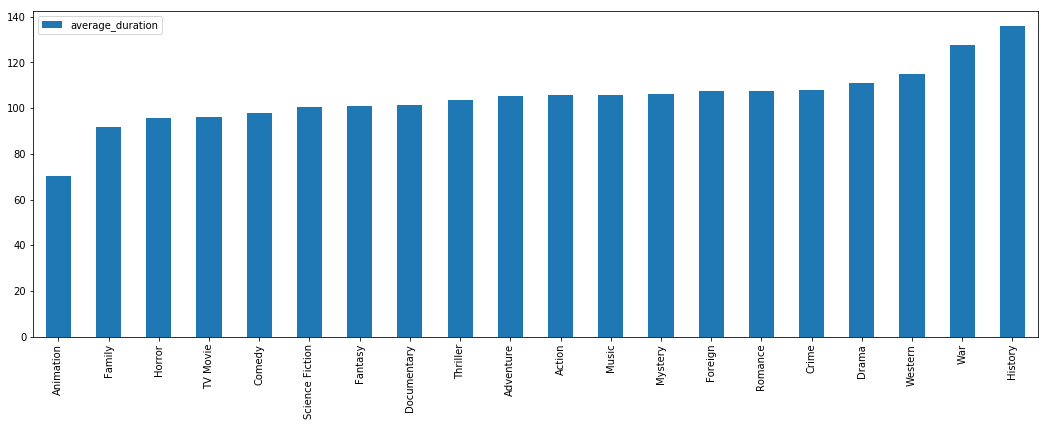

In [52]:
genre_runtime_df.plot(kind='bar', figsize=(18,6));

### <font color=red>Answer to question #3</font>

There doesn't seem to be a noticeable difference in movie runtines, with the exception of two:
- History and War films are, on average, noticeably longer than other films
- Animation films are, on average, noticeably shorter than other films

## <font color=green>4. What is the average budget depending on the genre?</font>

Since the dataframe has multiple genres per film, we again have to create a specific dataframe for this operation

In [53]:
genre_budget_df = pd.DataFrame(columns = ['genre','budget'])
genre_budget_df.budget = genre_budget_df.budget.astype('float64')
genre_budget_df.dtypes

genre      object
budget    float64
dtype: object

In [54]:
genre_budget_df

,genre,budget


Let's see if all the data we are going to use is valid

In [55]:
df_tmdb.budget_adj.min()

0.0

I can alredy see that there are movies with 0 as budget, those won't work. But, how many are there ?

In [56]:
df_tmdb.query('budget_adj == 0').shape[0]

5636

Wow, 5636 is a lot of movies. Instead of dropping them let's make a temporary DataFrame

In [57]:
df_movies_with_budget = df_tmdb.query('budget_adj != 0')
df_movies_with_budget.shape[0]

5164

In [58]:
for index, movie in df_movies_with_budget.iterrows():
    for genre in list_of_genres:
        if genre in movie.genres:
            temp_row = {'genre':genre,'budget':movie.budget_adj}
            genre_budget_df = genre_budget_df.append(temp_row, ignore_index=True)

In [59]:
genre_budget_df.shape[0]

13590

In [60]:
genre_budget_df

,genre,budget
0,Action,1.379999e+08
1,Adventure,1.379999e+08
2,Science Fiction,1.379999e+08
3,Thriller,1.379999e+08
4,Action,1.379999e+08
5,Adventure,1.379999e+08
6,Science Fiction,1.379999e+08
7,Thriller,1.379999e+08
8,Adventure,1.012000e+08
9,Science Fiction,1.012000e+08


In [61]:
#group by genre and get average budget
genre_budget_df = genre_budget_df.groupby('genre').mean()

#sort them for easier viewing
genre_budget_df.sort_values(by='budget',inplace=True)

#Divide by 1,000,000 to display the values as MM in the chart, easier to see
genre_budget_df = genre_budget_df.budget.apply(lambda x: x/1000000)

#view data
genre_budget_df

genre
Documentary         5.141867
TV Movie            5.492844
Foreign            13.325565
Horror             16.615745
Drama              30.551118
Romance            31.167858
Music              31.357732
Comedy             34.739261
Crime              35.426946
Mystery            35.865156
Thriller           36.639471
History            48.472024
War                50.394310
Science Fiction    51.762269
Western            54.622669
Action             55.025841
Family             63.599472
Fantasy            67.614541
Animation          68.005575
Adventure          71.337550
Name: budget, dtype: float64

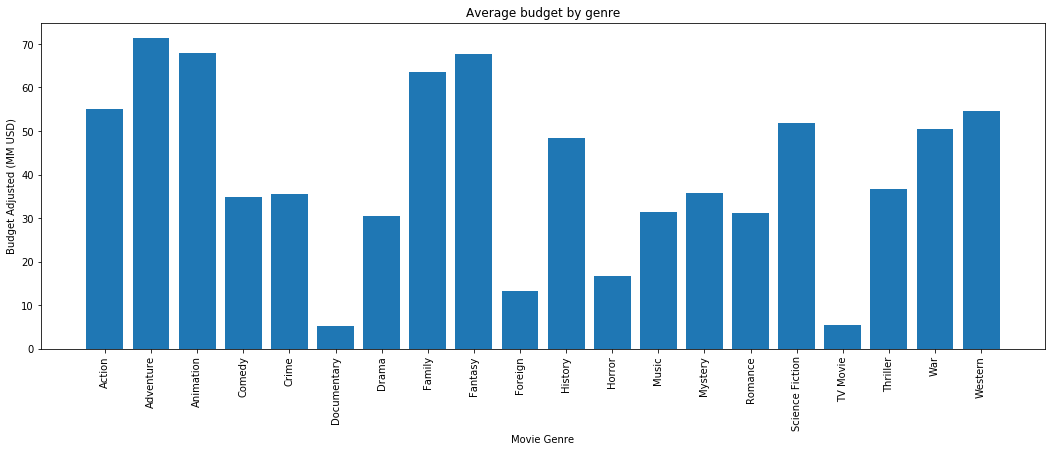

In [62]:
x_axis = genre_budget_df.index
y_axis = genre_budget_df.values
plt.figure(figsize=(18,6))
plt.bar(x_axis, y_axis);
plt.title('Average budget by genre')
plt.xlabel('Movie Genre');
plt.xticks(rotation='vertical')
plt.ylabel('Budget Adjusted (MM USD)');

Let's look at them sorted

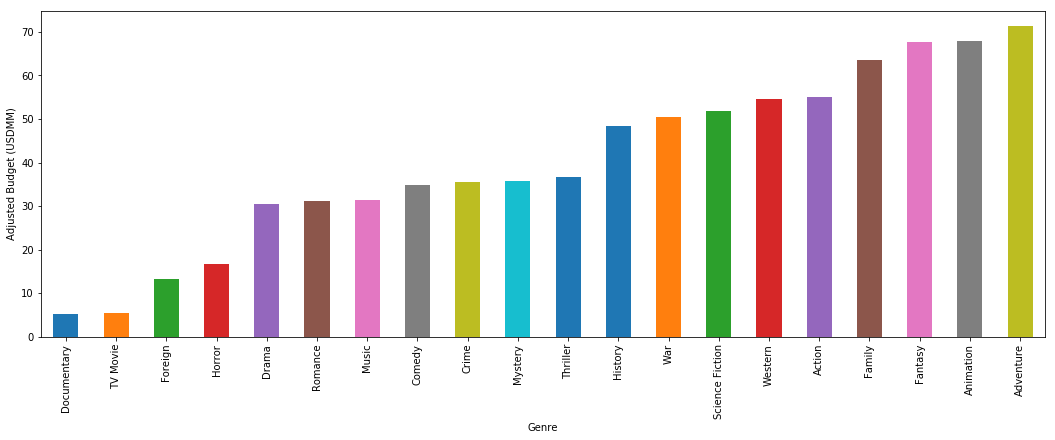

In [63]:
question_4_subplot = genre_budget_df.plot(kind='bar', figsize=(18,6));
question_4_subplot.set_ylabel('Adjusted Budget (USDMM)');
question_4_subplot.set_xlabel('Genre');

### <font color=red>Answer to question #4</font>

Animation, Fantasy and Adventure are the Top3 most expensive films to produce, while Documentaries, TV Movies and Foreign Films are the most affordable (Or have the lowest budget)

## <font color=green>5. Have movies become more expensive over time (after considering inflation)?</font>

In [64]:
budget_year_df = df_tmdb.groupby(by='release_year').budget_adj.mean()
budget_year_df = budget_year_df.to_frame()
#Divide by 1,000,000 to represent values in MM
budget_year_df = budget_year_df.apply(lambda x : x / 1000000)

In [65]:
budget_year_df.tail(30)

,budget_adj
release_year,
1986,11.583502
1987,10.892022
1988,11.848895
1989,13.963965
1990,16.308705
1991,17.650941
1992,16.846153
1993,15.176814
1994,17.822893


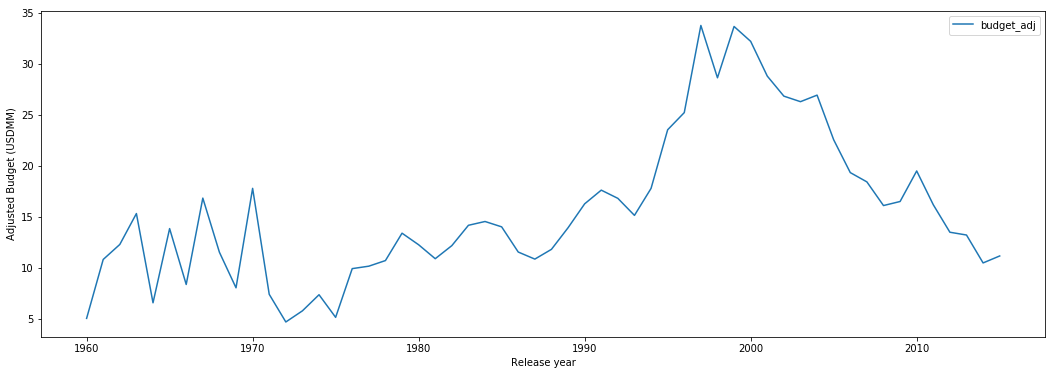

In [66]:
question_5_subplot = budget_year_df.plot(kind='line', figsize=(18,6));
question_5_subplot.set_ylabel('Adjusted Budget (USDMM)');
question_5_subplot.set_xlabel('Release year');

### <font color=red>Answer to question #5</font>

There seems to have been a spike in the late 90s and early 2000s, however, the budget of films decreased radically, perhaps due to advancements in editing or renting equipment, or simply because there weren't sufficient returns on those budgets.

Could also be the peak of Adventure and Animation films since, as we saw in the previous questions, are the most expensive films to produce.

The answer is **yes**, movies have  become more expensive to produce over time, after adjusting for inflation. However, if we were to draw a CAGR from the 1960 to 2015, it would show a very minimal increase. We must consider the drastic spike of late 90s/early 2000s to appreciate the increase in cost over time

## <font color=green>6. What are the most succesful movies by revenue? How about for adjusted revenue?</font>

### By revenue

In [67]:
most_successful_movies_by_revenue_df = df_tmdb.sort_values(by='revenue', ascending=False).head(5)
#Divide the revenue by 9 zeros to show in BN
most_successful_movies_by_revenue_df['revenue'] = most_successful_movies_by_revenue_df['revenue'].apply(lambda x : x/1000000000)
most_successful_movies_by_revenue_df[['original_title','revenue']]

,original_title,revenue
1386,Avatar,2.781506
3,Star Wars: The Force Awakens,2.068178
5231,Titanic,1.845034
4361,The Avengers,1.519558
0,Jurassic World,1.513529


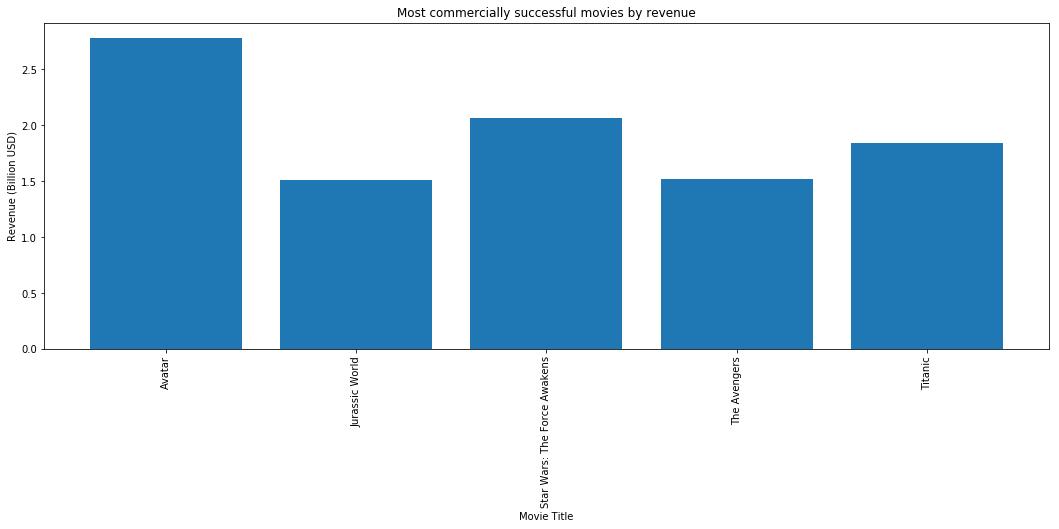

In [73]:
x_axis = most_successful_movies_by_revenue_df.original_title
y_axis = most_successful_movies_by_revenue_df.revenue
plt.figure(figsize=(18,6))
plt.bar(x_axis, y_axis);
plt.title('Most commercially successful movies by revenue')
plt.xlabel('Movie Title');
plt.xticks(rotation='vertical')
plt.ylabel('Revenue (Billion USD)');

### By adjusted revenue

In [69]:
most_successful_movies_by_adjusted_revenue_df = df_tmdb.sort_values(by='revenue_adj', ascending=False).head(5)
#Divide the revenue by 9 zeros to show in BN
most_successful_movies_by_adjusted_revenue_df['revenue_adj'] = most_successful_movies_by_adjusted_revenue_df['revenue_adj'].apply(lambda x : x/1000000000)
most_successful_movies_by_adjusted_revenue_df[['original_title','revenue_adj']]

,original_title,revenue_adj
1386,Avatar,2.827124
1329,Star Wars,2.789712
5231,Titanic,2.506406
10594,The Exorcist,2.167325
9806,Jaws,1.907006


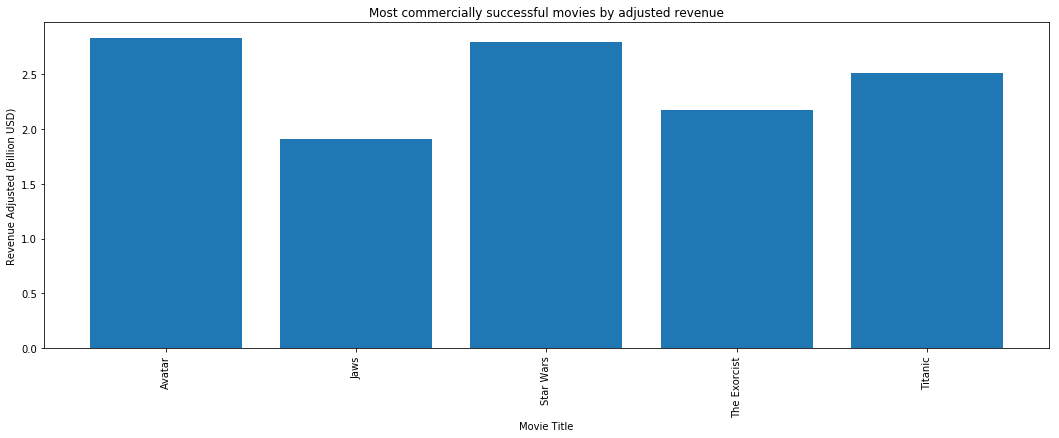

In [72]:
x_axis = most_successful_movies_by_adjusted_revenue_df.original_title
y_axis = most_successful_movies_by_adjusted_revenue_df.revenue_adj
plt.figure(figsize=(18,6))
plt.bar(x_axis, y_axis);
plt.title('Most commercially successful movies by adjusted revenue')
plt.xlabel('Movie Title');
plt.xticks(rotation='vertical')
plt.ylabel('Revenue Adjusted (Billion USD)');

### <font color=red>Answer to question #6</font>

The most commercially successful movies by adjusted revenueare:
1. Avatar
2. Star Wars
3. Titanic
4. The Exorcist
5. Jaws

## <font color=green>7. What are the most succesful movies by rating?</font>

In [78]:
most_successful_movies_by_rating_df = df_tmdb.sort_values(by='vote_average', ascending=False).head(5)
most_successful_movies_by_rating_df[['vote_count','vote_average','original_title']].head()

,vote_count,vote_average,original_title
3894,14,9.2,The Story of Film: An Odyssey
538,11,8.9,The Mask You Live In
1200,41,8.8,Black Mirror: White Christmas
2269,27,8.8,Life Cycles
6911,23,8.7,Pink Floyd: Pulse


While I agree that Black Mirror is the greatest show ever, these films have very limited vote counts, so let's see what the average vote count is 

In [79]:
df_tmdb.vote_count.describe()

count    10800.000000
mean       218.600741
std        577.165055
min         10.000000
25%         17.000000
50%         39.000000
75%        147.000000
max       9767.000000
Name: vote_count, dtype: float64

The average is 218 votes per film, but there's a max of over 9,000! I am curious how many films have 4 digits of vote counts

In [115]:
df_tmdb.query('vote_count > 999').shape[0]

564

I am content with the amount of films (564) that have gathered over 1,000 votes, I will be choosing the most succesful from that datarame.

In [101]:
most_successful_movies_by_rating_df = df_tmdb.query('vote_count > 999')
most_successful_movies_by_rating_df = most_successful_movies_by_rating_df.sort_values(by='vote_average', ascending=False).head(5)

In [107]:
most_successful_movies_by_rating_df[['original_title','vote_average']]

,original_title,vote_average
4178,The Shawshank Redemption,8.4
7269,The Godfather,8.3
650,Whiplash,8.2
4177,Pulp Fiction,8.1
4179,Forrest Gump,8.1


Now THAT is a list that we can all agree on

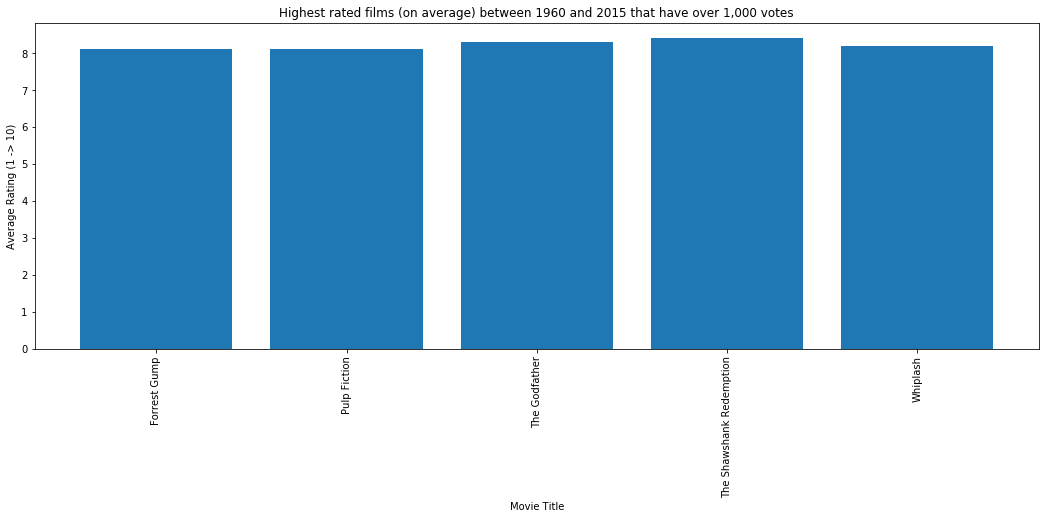

In [114]:
x_axis = most_successful_movies_by_rating_df.original_title
y_axis = most_successful_movies_by_rating_df.vote_average
plt.figure(figsize=(18,6))
plt.bar(x_axis, y_axis);
plt.title('Highest rated films (on average) between 1960 and 2015 that have over 1,000 votes')
plt.xlabel('Movie Title');
plt.xticks(rotation='vertical')
plt.ylabel('Average Rating (1 -> 10)');

### <font color=red>Answer to question #7</font>

The highest rated films (on average) between 1960 and 2015 that have over 1,000 votes are:
1. The Shawshank Redemption
2. The Godfather
3. Whiplash (What a surprise)
4. Pulp Fiction
5. Forrest Gump

## <font color=green>8. What are the average amount of movies a director has done?</font>
   

In [199]:
amount_of_films_per_director_df = df_tmdb.groupby(by='director').size()
amount_of_films_per_director_df.head()

director
 FrÃ©dÃ©ric Jardin            1
A. Todd Smith                 1
A.R. Murugadoss               1
Aaron Aites                   1
Aaron Blaise|Robert Walker    1
dtype: int64

In [200]:
amount_of_films_per_director_df.max()

45

In [201]:
amount_of_films_per_director_df.describe()

count    5056.000000
mean        2.136076
std         2.526159
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        45.000000
dtype: float64

In [202]:
amount_of_films_per_director_df.sort_values(ascending=False).head(5)

director
Woody Allen         45
Clint Eastwood      34
Steven Spielberg    29
Martin Scorsese     29
Ridley Scott        23
dtype: int64

Let's group them by the following
- 1 Film
- 2 to 5 Films
- 6 to 20 Films
- 20+ Films

In [220]:
groups = ['1 film', '2 to 5 films', '6 to 20 films', '20+ films']

In [204]:
amount_of_films_per_director_df = amount_of_films_per_director_df.to_frame()
amount_of_films_per_director_df.rename(columns={0:'film_count'}, inplace=True)

In [205]:
one_film_series = amount_of_films_per_director_df.query('film_count == 1').sum()
two_to_five_films_series = amount_of_films_per_director_df.query('film_count > 1 & film_count < 6').sum()
six_to_twenty_films_series = amount_of_films_per_director_df.query('film_count > 5 & film_count < 21').sum()
twenty_plus_films_series = amount_of_films_per_director_df.query('film_count > 20').sum()

values = [one_film_series, two_to_five_films_series, \
          six_to_twenty_films_series, twenty_plus_films_series]

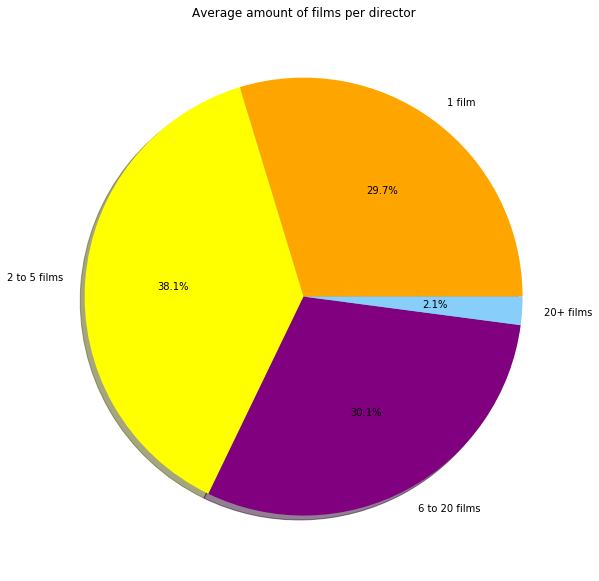

In [221]:
colors = ['orange', 'yellow', 'purple', 'lightskyblue', 'coral']
fig = plt.figure(figsize=(8,8))
plt.pie(values, labels=groups, colors=colors, autopct='%1.1f%%', shadow=True);
plt.tight_layout()
plt.title('Average amount of films per director')
plt.show()

### <font color=red>Answer to question #8</font>

The vast majority of directors have 2 to 5 films, followed by (surprisingly) and equal amount that have, on one side, 1 film, and on the other side, 6 to 20 films.

Finally, there 2% of our sample size are directors with over 20 films in their career. **Impressive**.

## <a id='conclusions'></a>
## Conclusions

Most of the answers could have been common knowledge, however it is different "thinking" it is the truth vs validating it with data. Most of the answers were expected, however I was surprised by the budget of films for the past 55 years, and for the last question about the average amount of movies a director has.

The answers to each question was listed at the end of the exploratory data analysis for each of the questions.

## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [224]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0